In [13]:
def gauden1d(xsp, xax, sd):
    out = np.zeros(xax.shape[0])
    denorm = 1/(sd * np.sqrt(2 * np.pi))
    for i in range(xsp.shape[0]):
        out += denorm * np.exp((-1/2) * np.square( (xsp[i]-xax)/sd  ))
    return out


In [30]:
# # Example of a simulation
# It is just a simulation of a rat running rightward in an environment packed with CA3 place cells
# with directionally tuned sensory input and synaptic weights. Preferred angles are pseudo-randomized.
# The configuration of this script does not produce phase precession/ theta sequences. One could produce
# theta sequences by adding asymmetrical connectivity (oriented in the same direction as the movement)

from os.path import join
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import pickle

from library.simulation_GoalNet import simulate_SNN
def load_pickle(fp):
    with open(fp, "rb") as f:
        f_dict = pickle.load(f)
    return f_dict

def save_pickle(fp, data):
    with open(fp, 'wb') as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

# # ================================= Network Parameters ==========================================
config_dict = dict()
config_dict['dt'] = 0.1

# # Izhikevich's model
config_dict['izhi_a_ex'] = 0.035
config_dict['izhi_b_ex'] = 0.2
config_dict['izhi_c_ex'] = -60
config_dict['izhi_d_ex'] = 8
config_dict['V_ex'] = 0  # Reversal potential for excitatory ion channel
config_dict['V_thresh'] = 30
config_dict['spdelay'] = int(2/config_dict['dt'])  # 2ms time delay = 20 indices

# # Theta inhibition
config_dict['theta_amp'] = 7
config_dict['theta_f'] = 10

# Positional drive
config_dict['EC_phase_deg'] = 290
config_dict['Ipos_max'] = 2
config_dict['Ipos_sd'] = 3
config_dict['Iangle_diff'] = 8

# Sensory tuning
config_dict['xmin'] = -20
config_dict['xmax'] = 20
config_dict['nn'] = 40

# Synapse parameters
config_dict['tau_gex'] = 12

# Goal-directed drive
config_dict['goal_x'] = 0
config_dict['Imax_goal'] = 2
config_dict['Isd_goal'] = 8
config_dict['Imax_angle_goal'] = 20

# # Weights
# CA3-CA3
config_dict['wmax'] = 10
config_dict['wsd'] = 3
config_dict['wmax_angle'] = 0
config_dict['wsd_angle'] = 2.5

dt = config_dict['dt']

# 0 deg
traj_r = 25
t = np.arange(0, 2.25e3, dt)
traj_x = np.linspace(-traj_r, traj_r, t.shape[0])
traj_a = np.zeros(traj_x.shape[0])
BehDF0 = pd.DataFrame(dict(t=t, traj_x=traj_x, traj_a=traj_a))

# 180 deg
t = np.arange(0, 2.25e3, dt)
traj_x = np.linspace(traj_r, -traj_r, t.shape[0])
traj_a = np.ones(traj_x.shape[0]) * np.pi
BehDF180 = pd.DataFrame(dict(t=t, traj_x=traj_x, traj_a=traj_a))

BehDFs = [BehDF0, BehDF180]
Behlabels = [0, 180]
save_dir = join('sim_results', 'goalnet')
os.makedirs(save_dir, exist_ok=True)

for i in range(2):
    save_pth = join(save_dir, 'goalnet_%d-deg.pkl'%(Behlabels[i]))
    print('Simulating ' + save_pth)
    simdata = simulate_SNN(BehDFs[i], config_dict, store_Activity=True, store_w=True)
    save_pickle(save_pth, simdata)
    del simdata


Simulating sim_results\goalnet\goalnet_0-deg.pkl
Simulation 22400/22500
Simulation time = 2.42s
Simulating sim_results\goalnet\goalnet_180-deg.pkl
Simulation 22400/22500
Simulation time = 2.25s


Text(0.5, 0.98, 'directionality')

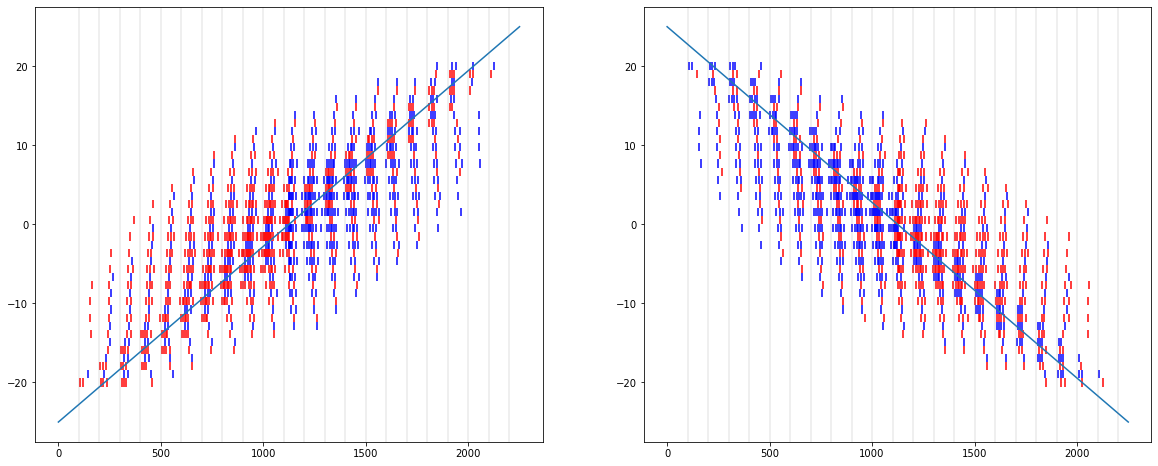

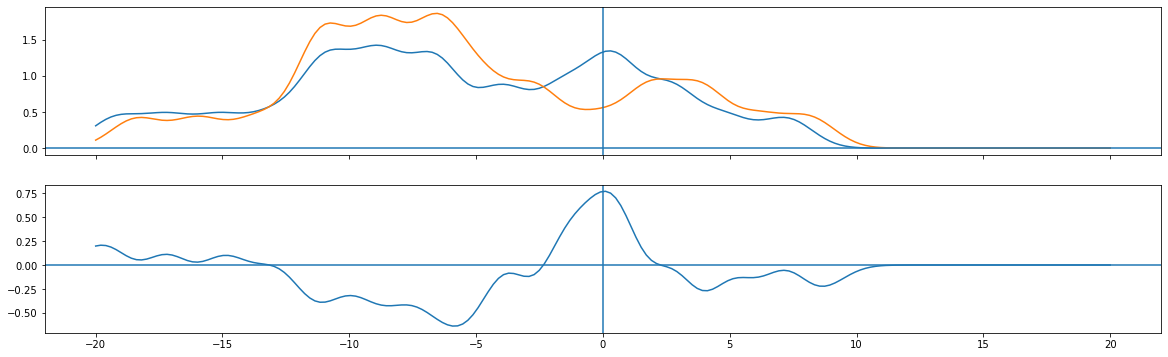

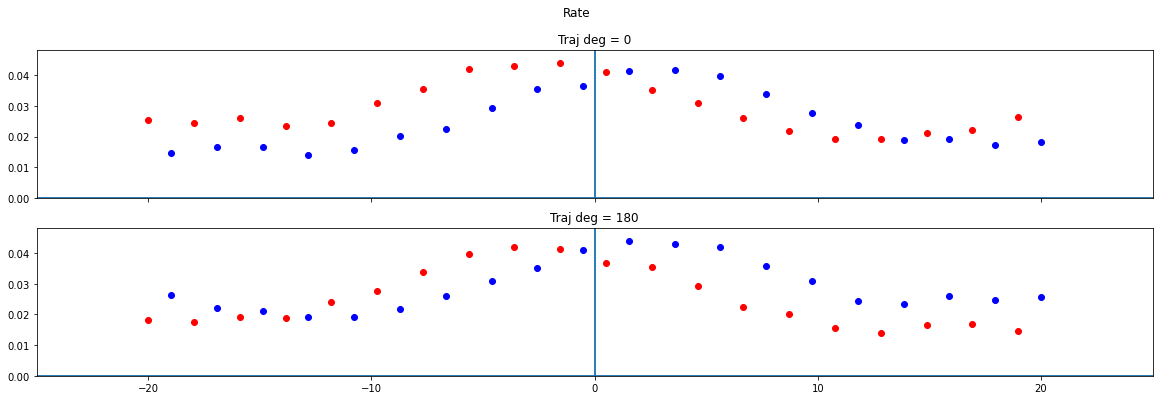

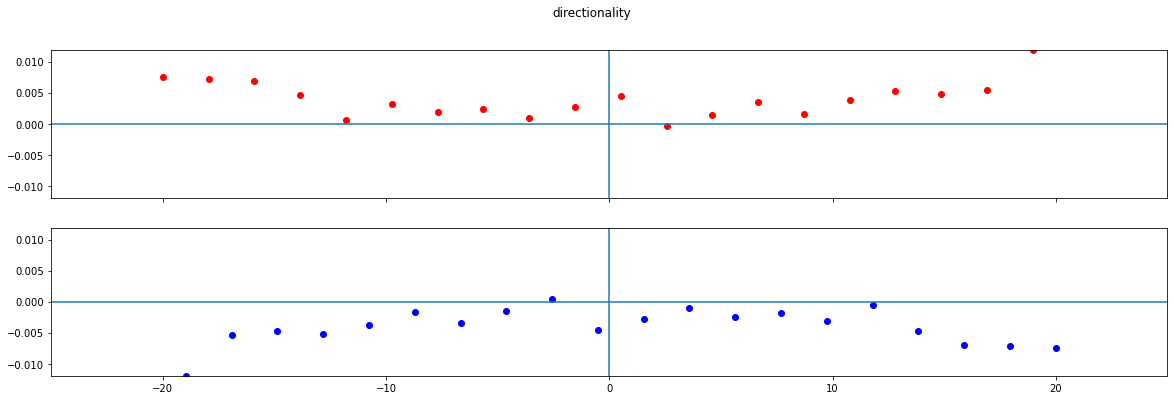

In [31]:
load_dir = join('sim_results', 'goalnet')


fig_ras, ax_ras = plt.subplots(1, 2, figsize=(20, 8))
fig_lrate, ax_lrate = plt.subplots(2, 1, figsize=(20, 6), sharex=True)
fig_rate, ax_rate = plt.subplots(2, 1, figsize=(20, 6), sharex=True, sharey=True)
fig_dir, ax_dir = plt.subplots(2, 1, figsize=(20, 6), sharex=True, sharey=True)
nn = 40
rate_both = np.zeros((nn, 2))
xax = np.linspace(-20, 20, 200 )
den_both = np.zeros((xax.shape[0], 2))
for axi in range(2):
    simdata = load_pickle(join(load_dir, 'goalnet_%d-deg.pkl'%(Behlabels[axi])))
    BehDF = simdata['BehDF']
    SpikeDF = simdata['SpikeDF']
    NeuronDF = simdata['NeuronDF']
    MetaData = simdata['MetaData']
    config_dict = simdata['Config']
    ActivityData = simdata['ActivityData']
    t = BehDF['t'].to_numpy()
    traj_x = BehDF['traj_x'].to_numpy()
    xtun = NeuronDF['neuronx'].to_numpy()
    atun = NeuronDF['neurona'].to_numpy()
    theta_phase_plot = BehDF['theta_phase_plot'].to_numpy()
    Igoal = ActivityData['Igoal']
    allnidx = NeuronDF['neuronid'].to_numpy()

    dx = xtun[1] - xtun[0]
    for nidx in allnidx:
        tidxsp = SpikeDF[SpikeDF['neuronid'] == nidx]['tidxsp'].to_numpy()
        tsp = t[tidxsp]
        rate_both[nidx, axi] = tsp.shape[0] / (tsp.max() - tsp.min())
        rasc = 'r' if atun[nidx] == 0 else 'b'
        ax_ras[axi].eventplot(tsp,  lineoffsets=xtun[nidx], linelengths=dx, color=rasc)

    ax_ras[axi].plot(t, traj_x)
    # Draw lines for theta cycles
    theta_cutidx = np.where(np.diff(theta_phase_plot) < -6)[0]
    for i in theta_cutidx:
        ax_ras[axi].axvline(t[i], c='gray', linewidth=0.25)

    # Location rate
    select_nidx = 11
    tidxsp = SpikeDF[SpikeDF['neuronid'] == select_nidx]['tidxsp'].to_numpy()
    tsp = t[tidxsp]
    xsp = traj_x[tidxsp]
    den_both[:, axi] = gauden1d(xsp, xax, 1)

ax_lrate[0].plot(xax, den_both[:, 0])
ax_lrate[0].plot(xax, den_both[:, 1])
ax_lrate[1].plot(xax, den_both[:, 0]- den_both[:, 1])
for i in range(2):
    ax_lrate[i].axhline(0)
    ax_lrate[i].axvline(0)

# Rate & Dir
atunall = [0, np.pi]
rate_max  = np.max(np.abs(rate_both))
rate_bias_max = np.max(np.abs(rate_both[:, 0] - rate_both[:, 1]))
for axi in [0, 1]:
    atunthis = atun == atunall[axi]
    xtun_this = xtun[atunthis]
    rate_this = rate_both[atunthis, :]
    rate_bias = rate_this[:, 0] - rate_this[:, 1]
    rasc = 'r' if axi == 0 else 'b'
    for traji in [0, 1]:
        ax_rate[traji].scatter(xtun_this, rate_this[:, traji], marker='o', color=rasc)
        ax_rate[traji].axhline(0)
        ax_rate[traji].axvline(0)
        ax_rate[traji].set_xlim(-25, 25)
        ax_rate[traji].set_ylim(0, rate_max*1.1)
        ax_rate[traji].set_title('Traj deg = %d'%(Behlabels[traji]))
    ax_dir[axi].scatter(xtun_this, rate_bias, marker='o', color=rasc)
    ax_dir[axi].axhline(0)
    ax_dir[axi].axvline(0)
    ax_dir[axi].set_xlim(-25, 25)
    ax_dir[axi].set_ylim(-rate_bias_max, rate_bias_max)



fig_rate.suptitle('Rate')
fig_dir.suptitle('directionality')


In [32]:
from library.simulation_GoalNet import circgaufunc1d, gaufunc1d

NeuronDF

,neuronid,neuronx,neurona,neurontype
0,0,-20.000000,0.000000,CA3
1,1,-18.974359,3.141593,CA3
2,2,-17.948718,0.000000,CA3
3,3,-16.923077,3.141593,CA3
4,4,-15.897436,0.000000,CA3
5,5,-14.871795,3.141593,CA3
6,6,-13.846154,0.000000,CA3
7,7,-12.820513,3.141593,CA3
8,8,-11.794872,0.000000,CA3
9,9,-10.769231,3.141593,CA3


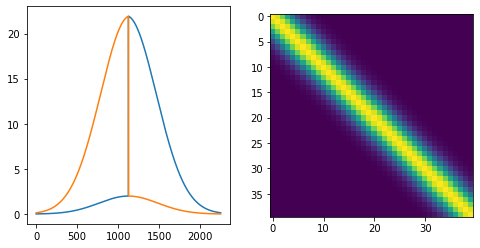

In [33]:
fig2, ax2 = plt.subplots(1, 2, figsize=(8, 4))
ax2[0].plot(t, Igoal[:, 20])
ax2[0].plot(t, Igoal[:, 19])

ax2[1].imshow(MetaData['w'])